In [11]:
import base64

from PIL import Image
from netCDF4 import Dataset
import numpy as np
import cv2
import os
import re
import time
import base64
import glob
import re
import numpy as np
import pandas as pd
import datetime
from scipy import interpolate
import cv2
from PIL import Image
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
os.chdir('/mnt/sdb1/wscho/Jobs/gk2aICT/src/tools/')
from api_gk2a import down_gk2a

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
os.chdir('/mnt/sdb1/wscho/Jobs/gk2aICT/')
from src.config import (
    LOCAL_GK2A_DIR,
    LATLON_DIR
)
from src.variables import (
    VAR2DSKEY,
    FD_VAR2FILE,
)
from src.tools.clip import (
    GK2AFDProcessor,
    GK2AEAProcessor,
)
from src.utils import (
    read_gk2a_data
)
from src.tools.cloud_albedo import get_cloud_albedo


In [1]:
ko_range = {
    'ullatitude': 42.0,
    'ullongitude': 124.0,
    'lrlatitude': 33.0,
    'lrlongitude': 130.0,
}
ea_range = {
    'ullatitude': 53,
    'ullongitude': 77,
    'lrlatitude': 11,
    'lrlongitude': 150,
}
etc_range = {
    'ullatitude': 38.0,
    'ullongitude': 126.0,
    'lrlatitude': 37.0,
    'lrlongitude': 128.0,
}
jeju_range = {
    'ullatitude': 34.1,
    'ullongitude': 125.3,
    'lrlatitude': 32.7,
    'lrlongitude': 127.7,
}

In [2]:
def get_resize_image(arr, resize=(1000, 800),
                          normalize=True):
    
    if normalize:
        arr = (arr - arr.min()) / (arr.max() - arr.min()) * 255
    
    # resize image
    img = Image.fromarray(arr.astype('uint8')).resize(resize[::-1])
    arr = np.array(img)
    
    return arr

In [3]:
def dense_optical_flow(prev_frame, next_frame):
    
    def normalize(cld):
        return (cld.astype('float')*255/2.).astype('uint8')
    
    prev_frame = normalize(prev_frame)
    next_frame = normalize(next_frame)
    
    flow = cv2.calcOpticalFlowFarneback(
        prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    
    return prev_frame, next_frame, flow

In [4]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [5]:
def draw_flow(img, flow, step=16):
    
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

In [6]:
base_dir  = '/mnt/sdb1/wscho/data_for_research/ICTgk2a/'
target_date = '20230503'

In [13]:
cld_path    =  os.path.join(base_dir, target_date, 'LE2' , 'DCOEW'.lower())
ctf_path    =  os.path.join(base_dir, target_date, 'LE2' , 'CLD'.lower())
# vec_path   =  os.path.join(base_dir, target_date, 'LE2' , 'AMV-WV069-CD'.lower())
latlon_path =  os.path.join(base_dir, 'latlon')


clist   =  glob.glob(os.path.join(cld_path, '*.nc'))
ctflist =  glob.glob(os.path.join(ctf_path, '*.nc'))
# alist   =  glob.glob(os.path.join(aero_path, '*.nc')) 
# vlist  =  glob.glob(os.path.join(vec_path, '*.nc'))
llist   =  glob.glob(os.path.join(latlon_path, '*.nc'))

clist.sort()
ctflist.sort()
# alist.sort()
# vlist.sort()

In [14]:
gk2a_proc = GK2AEAProcessor(gk2a_filename=clist[0])
BOUNDARY_OPTION = True

In [15]:
# 구름 OD
cld = []
for data in clist:
    ds = Dataset(data)
    cld.append(ds['COT'])

In [17]:
cld_clip = [gk2a_proc.cut_with_latlon(cld_x, **ko_range, boundary = BOUNDARY_OPTION) for cld_x in cld[0:15]]

In [18]:
cld_clip[0]

array([[1.0059999e+01, 9.5900002e+00, 1.0450000e+01, ..., 6.5535000e+04,
        6.5535000e+04, 6.5535000e+04],
       [8.2399998e+00, 8.4399996e+00, 7.8699999e+00, ..., 6.5535000e+04,
        6.5535000e+04, 6.5535000e+04],
       [6.6799998e+00, 8.4399996e+00, 7.8699999e+00, ..., 6.5535000e+04,
        6.5535000e+04, 6.5535000e+04],
       ...,
       [6.5535000e+04, 6.5535000e+04, 6.5535000e+04, ..., 4.2599998e+00,
        6.2700000e+00, 6.2700000e+00],
       [6.5535000e+04, 6.5535000e+04, 6.5535000e+04, ..., 3.3699999e+00,
        6.5535000e+04, 3.0000000e+00],
       [6.5535000e+04, 6.5535000e+04, 6.5535000e+04, ..., 6.5535000e+04,
        6.5535000e+04, 2.8899999e+00]], dtype=float32)

In [124]:
np.log(cld_clip[0]).min()

-0.9162908

In [125]:
np.log(cld_clip[0]).max()

11.09034

In [146]:
cld_clip[0].max()

158.48

(-0.5, 764.5, 983.5, -0.5)

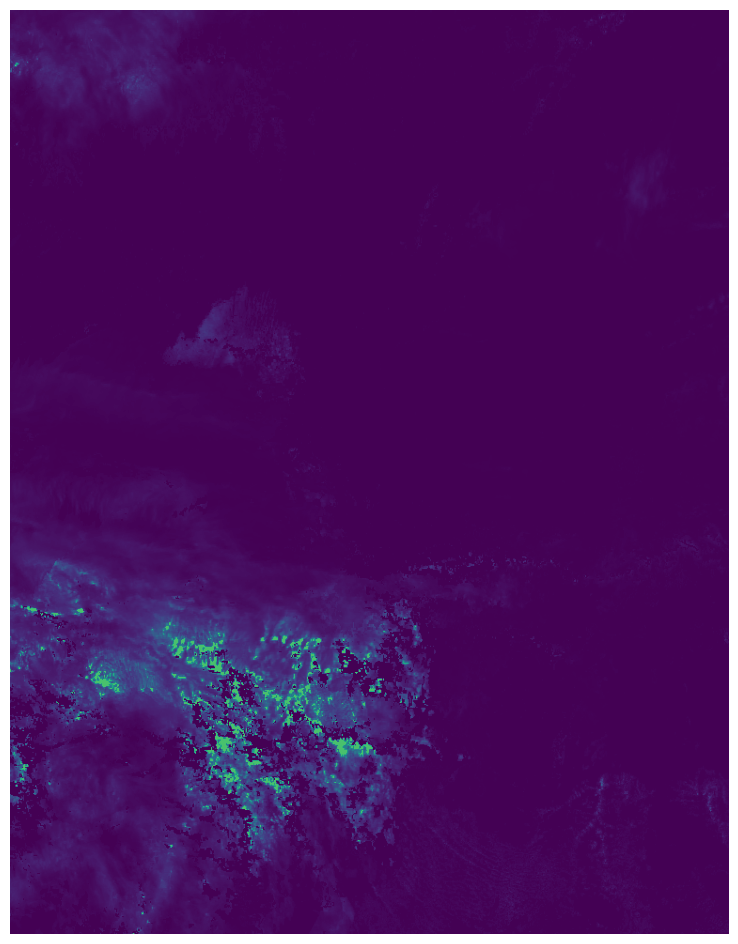

In [154]:
fig, ax = plt.subplots(figsize=(12, 12))

# levels =np.arange(-1,4.1,0.1)
# c=ax.contourf(np.log(cld_clip[7]),levels = levels, cmap = 'gray',extend = 'None')
ax.patch.set_facecolor('black')

# levels =np.arange(-2,5.1,0.1)
cf = ax.imshow(cld_clip[0],cmap='viridis',vmax = 222)
# formatter = LogFormatter(10, labelOnlyBase=False) 
# cbar = fig.colorbar(cf,ticks =np.arange(-1,5,1), format = formatter)
# cbar.ax.set_yticklabels([10.0**cx for cx in np.arange(-1,5,1)])
# ax.invert_yaxis()
ax.axis('off')

# plt.title('Cloud Optical Depth - Korean Domain')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# c=ax.contour(cld[7].data,levels =[65535],colors='k')

levels = np.arange(-2,5.1,0.1)
cf = ax.imshow(con[0][2],cmap='jet')
# formatter = LogFormatter(10, labelOnlyBase=False) 
# cbar = fig.colorbar(cf,ticks =np.arange(-1,5,1), format = formatter)
# cbar.ax.set_yticklabels([10.0**cx for cx in np.arange(-1,5,1)])
ax.invert_yaxis()
ax.axis('off')

# plt.title('Cloud Optical Depth - Korean Domain')

In [ ]:
def cloud_centroid(var, size_thr = 0):
    
    #@ var      : var is input satellite img ( the data file must be {ncfilename}['{var_name}'] )
    #@ size_thr : size thr means a threshold for min. round size of cloud we want to detect ( in km )
    #@ g        : graph img has all components of variables in the function ( contour, centroid, rectangle )
    
    var[var == 65535.0] = 0
    var[var == 0] = 0.01  ## data qualifying
    var_c = get_resize_image(np.log(var),resize=var.shape)
    # k, var_c = cv2.threshold(var_c, 80, 255, cv2.THRESH_BINARY_INV , dst=None)
    # var_c = 255-var_c

    contours, hierarchy = cv2.findContours(var_c,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) ## calc. contour
    
    g        =   var.copy()
    cen      =   np.zeros(var_c.shape)
    rec      =   np.zeros(var_c.shape)
    cen_loc  =   []
    rec_size =   []
    
    g = cv2.cvtColor(var_c, cv2.COLOR_GRAY2BGR)

    con_len = [len(con) for con in contours]
    
    for idx, contour in enumerate(contours):
        
        if con_len[idx] >= (size_thr / 2):

            c = (0, 0, 160)
            # cv2.drawContours(g,contour,-1,c,1,1)               ## get contour

            mu = cv2.moments(contour)
            if mu['m00'] !=0:
                cx = int(mu['m10']/mu['m00'] + 1e-5)
                cy = int(mu['m01']/mu['m00'] + 1e-5)
                # cv2.circle(g,(cx,cy),2,(0,200,0),-1)           ## get centroid of contour
                cv2.circle(cen,(cx,cy),2,(0,200,0),-1)         ## get centroid of contour
                
                cen_loc.append((cx,cy))
                
            (x,y,w,h) = cv2.boundingRect(contour)
            # cv2.rectangle(g,(x,y),(x+w,y+h),(255,0,0),1)       ## get bounding box of contour
            cv2.rectangle(rec,(x,y),(x+w,y+h),(255,0,0),0)     ## get bounding box of contour

            rec_size.append((x,y,w,h))
            
            
#             rect = cv2.minAreaRect(contour)
#             box  = cv2.boxPoints(rect)
#             box  = np.int0(box)
#             cv2.drawContours(g,[box],0,(200,0,0),1)
#             cv2.drawContours(rec,[box],0,(200,0,0),1)          ## get min area bounding box of contour
            
    return contours, hierarchy, g, cen, rec, cen_loc, rec_size, var_c

In [ ]:
start = time.time()

con = [cloud_centroid(cld_x, size_thr = 1) for cld_x in cld_clip]

end = time.time()

print(f'\n| Calc. Time : {end - start}sec |\n')

In [ ]:
s = time.time()

dn=2
tracker = cv2.TrackerCSRT_create()
reteval = []
init = con[0][2]

for n, rc_0 in enumerate(con[0][6]):
    
    print(rc_0)

    # 초깃값 설정

    tracker.init(init,rc_0)

    ret, rc = tracker.update(con[dn][2])

    # floate 형태로 rc값을 받으므로 int로 변환해서 list로 감싸고 tuple로 변환
    
    rc = tuple([int(_) for _ in rc])

    cv2.rectangle(con[0][2], con[0][6][n], (255,0,0),2)
    cv2.rectangle(con[dn][2], rc, (255,0,0),2)

    reteval.append(ret)


    
    
    
fig, ax = plt.subplots(1, 2, figsize = (10,15))

for i in range(2):

    plt.rc('font', size= 30)
    ax[i].set_title(f'Time : t - {1 - i}')
    ax[i].imshow(con[(i)*dn][2])
    ax[i].axis('off')

fig.subplots_adjust(right=2, top=2)


e = time.time()
print(f'\n| Calc. Time : {e - s}sec |\n')

In [ ]:
# 동영상 열기
# 트래커 객체 생성

# Kernelized Correlation Filters
# KCF가 그나마 빠른 알고리즘
#tracker = cv2.TrackerKCF_create()

# Minimum Output Sum of Squared Error
# 빠르게 동작하는 편
#tracker = cv2.TrackerMOSSE_create()

# Discriminative Correlation Filter with Channel and Spatial Reliability
# 앞의 두 가지 방법보다 강인하게 추적을 함. 그대신 느림
tracker = cv2.TrackerKCF_create()

# GOTURN은 딥러닝 기반. 실행하려면 딥러닝 관련 파일을 다운받아서 가중치 파일을 저장해야지 동작 가능

# 첫 번째 프레임에서 추적 ROI 설정

# frame 이라는 이름으로 부분영상 추출
# 초깃값 설정
tracker.init(con[0][2], con[0][6][5])

# 매 프레임 처리


# 추척 $ ROI 사각형 업데이트
# 매 프래임마다 update하고 rc값 받아옴
ret, rc = tracker.update(con[1][2])
    
    # floate 형태로 rc값을 받으므로 int로 변환해서 list로 감싸고 tuple로 변환
rc = tuple([int(_) for _ in rc])
cv2.rectangle(con[1][2], rc, (255, 0, ), 2)

In [125]:
ret

True